In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# progress bar
from tqdm import tqdm

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

In this notebook, we explore the the level of noise in the information footprint that results from the so-called hitchhiking effect as well as how it scales as a function of library size. 


### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Noise increases as library size decreases

In [7]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -15

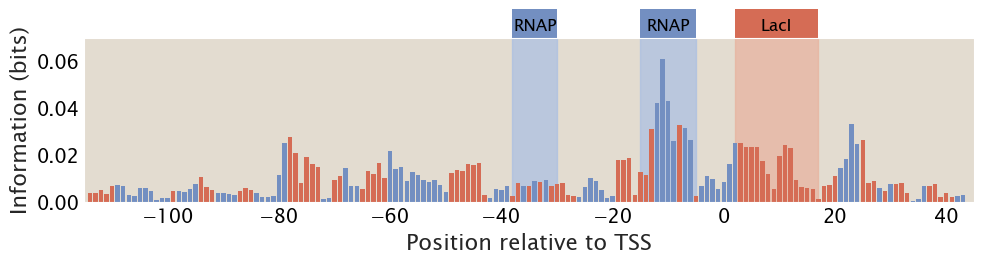

In [8]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        num_mutants=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../plots/library_size_fp.pdf',
                               annotate_stn=False)

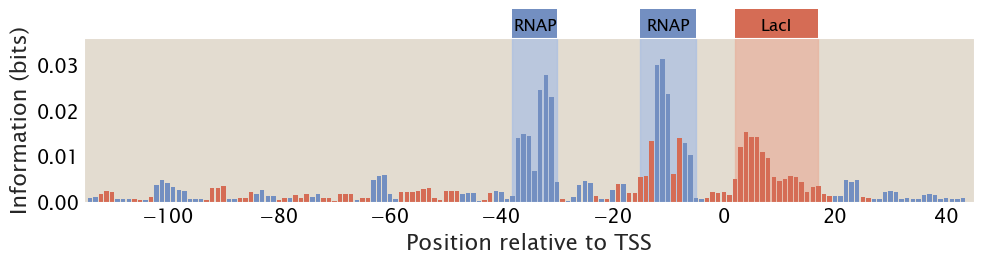

In [9]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        num_mutants=500)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../plots/library_size_fp2.pdf',
                               annotate_stn=False)

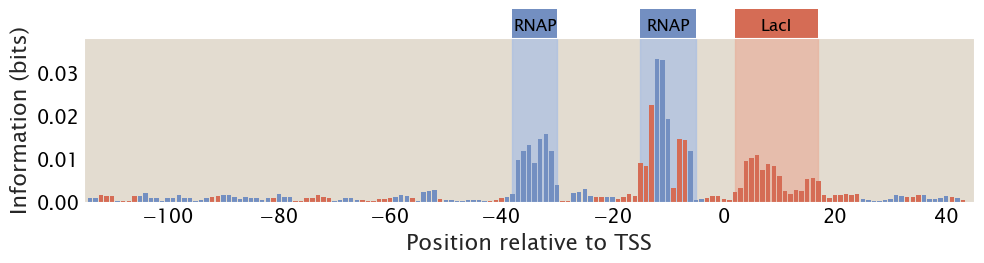

In [10]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        num_mutants=1000)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../plots/library_size_fp3.pdf',
                               annotate_stn=False)

### Plotting average signal and average noise as a function of library size

In [11]:
def get_signal(footprint, region_param):
    signal = np.sum(footprint[(region_param[0]+115):(region_param[1]+116)])
    length = region_param[1] - region_param[0] + 1
    return signal, length

In [12]:
library_size = np.rint(10 ** np.arange(2, 5.01, 0.1))

l_stn_ratio_rnap10 = []
l_stn_ratio_rnap35 = []
l_stn_ratio_lacI = []
for i in tqdm(range(len(library_size))):
    rnap10 = []
    rnap35 = []
    lacI = []
    for j in range(100):
        size = library_size[i]

        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                            *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                            num_mutants=int(size))
        
        nbins = 2
        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    l_stn_ratio_rnap10.append((np.mean(rnap10), np.std(rnap10)))
    l_stn_ratio_rnap35.append((np.mean(rnap35), np.std(rnap35)))
    l_stn_ratio_lacI.append((np.mean(lacI), np.std(lacI)))

100%|██████████| 31/31 [4:28:05<00:00, 518.87s/it] 


In [16]:
# Create DataFrame
df = pd.DataFrame({
    'Library Size': library_size,
    'rnap10_mean': [x[0] for x in l_stn_ratio_rnap10],
    'rnap10_std': [x[1] for x in l_stn_ratio_rnap10],
    'rnap35_mean': [x[0] for x in l_stn_ratio_rnap35],
    'rnap35_std': [x[1] for x in l_stn_ratio_rnap35],
    'lacI_mean': [x[0] for x in l_stn_ratio_lacI],
    'lacI_std': [x[1] for x in l_stn_ratio_lacI]
})

# Export to CSV
df.to_csv('../outputs/figure5.csv', index=False)

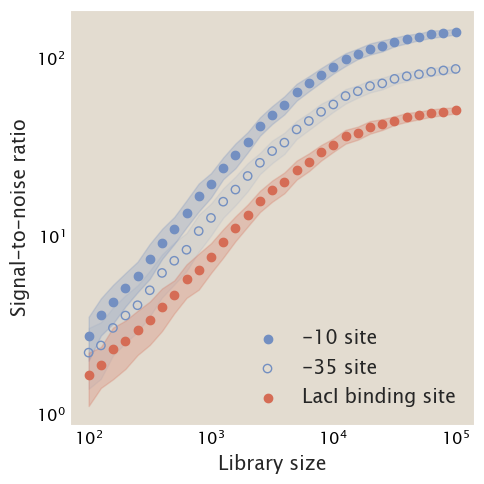

In [15]:
# plot signal-to-noise ratio vs library size
fig, ax = plt.subplots(figsize=(5, 5))
ax.fill_between(library_size,
                 np.asarray(l_stn_ratio_rnap10)[:, 0] - np.asarray(l_stn_ratio_rnap10)[:, 1],
                 np.asarray(l_stn_ratio_rnap10)[:, 0] + np.asarray(l_stn_ratio_rnap10)[:, 1],
                 color='#738FC1', alpha=0.25) 
ax.fill_between(library_size,
                np.asarray(l_stn_ratio_rnap35)[:, 0] - np.asarray(l_stn_ratio_rnap35)[:, 1],
                np.asarray(l_stn_ratio_rnap35)[:, 0] + np.asarray(l_stn_ratio_rnap35)[:, 1],
                color='#738FC1', alpha=0.1)
ax.fill_between(library_size,
                np.asarray(l_stn_ratio_lacI)[:, 0] - np.asarray(l_stn_ratio_lacI)[:, 1],
                np.asarray(l_stn_ratio_lacI)[:, 0] + np.asarray(l_stn_ratio_lacI)[:, 1],
                color='#D56C55', alpha=0.25)

ax.scatter(library_size, np.asarray(l_stn_ratio_rnap10)[:, 0],
           label='-10 site', color='#738FC1')
ax.scatter(library_size, np.asarray(l_stn_ratio_rnap35)[:, 0],
           label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(library_size, np.asarray(l_stn_ratio_lacI)[:, 0],
           label='LacI binding site', color='#D56C55')
ax.set_xscale('log')
ax.set_xlabel('Library size', fontsize=14)
ax.set_ylabel('Signal-to-noise ratio',fontsize=14)
ax.legend(loc='lower right', frameon=False, fontsize=14)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../plots/fig5/library_size.pdf')